# CellRank meets RNA velocity

In this tutorial, you will learn how to...

- use scVelo</cite> to compute RNA velocity, see the [scVelo docs](https://scvelo.readthedocs.io/) to learn more <cite data-cite="bergen:20,manno:18"></cite>. 
- set up CellRank's [VelocityKernel](https://cellrank.readthedocs.io/en/stable/api/cellrank.tl.kernels.VelocityKernel.html#) and compute a transition matrix based on RNA velocity. 
- combine the `VelocityKernel` with the [ConnectivityKernel](https://cellrank.readthedocs.io/en/stable/api/cellrank.tl.kernels.ConnectivityKernel.html) to emphasize gene expression similarity. 
- visualize the transition matrix in a low-dimensional embedding. 

We can summarize the workflow, from RNA velocity up to the transition matrix, in the following figure: 

<img src="_static/img/velocity_kernel_extended.jpg" width=800  alt="The `VelocityKernel` restricts velocity vectors to their local neighborhood to estimate a transition matrix.">

**Fig** | We combine RNA velocity with transcriptomic similarity to compute a cell-cell transition matrix, see our "CellRank for directed single-cell fate mapping" <cite data-cite="lange:22"></cite> manuscript to learn more. 

To demonstrate the appproach in this tutorial, we will use a scRNA-seq dataset of pancreas development at embyonic day E15.5 <cite data-cite="bastidas-ponce:19"></cite>. 

<div class="alert alert-info">
Important

If you want to run this on your own data, you will need...

- a scRNA-seq dataset which has been preprocessed to contain unspliced & spliced counts using a software like the [velocyto command line tool](http://velocyto.org/velocyto.py/tutorial/index.html#running-the-cli). 

</div> 

This tutorial notebook can be downloaded using the following [link](https://github.com/theislab/cellrank_notebooks/raw/master/tutorials/cellrank_meets_rna_velocity.ipynb).

## Import packages & data

In [16]:
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/theislab/cellrank@dev
    !pip install python-igraph

In [17]:
import scvelo as scv
import scanpy as sc
import cellrank as cr
import numpy as np

scv.settings.verbosity = 3
scv.settings.set_figure_params("scvelo")
cr.settings.verbosity = 2

In [18]:
import warnings

warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)

First, we need to get the data. The following commands downloads the `adata` object and saves it under `datasets/endocrinogenesis_day15.5.h5ad`. We visualize the fraction of spliced/unspliced reads; these are required to estimate RNA velocity. 

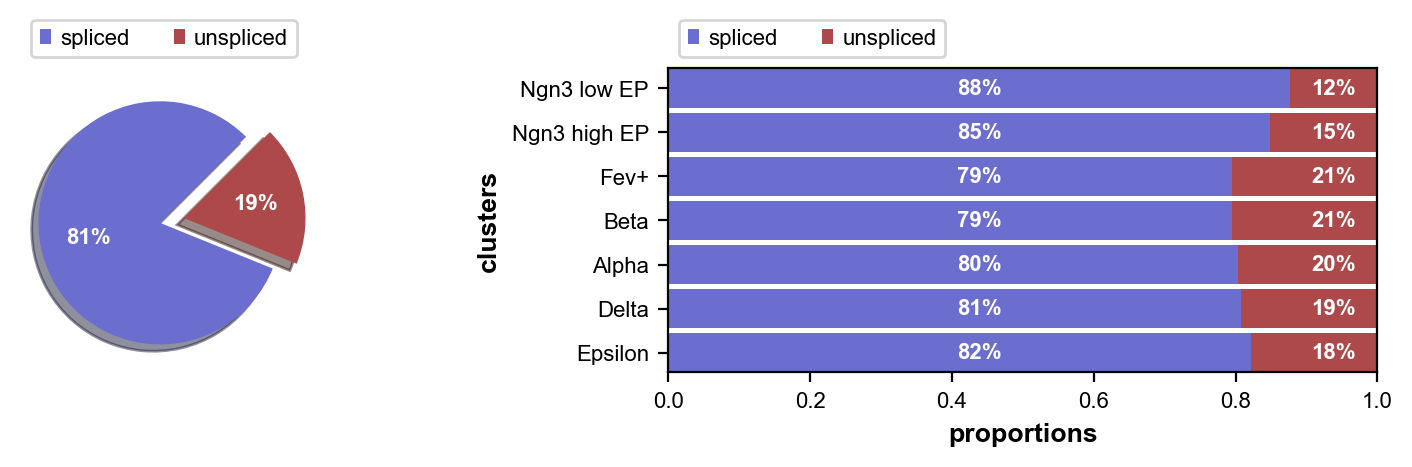

AnnData object with n_obs × n_vars = 2531 × 27998
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta', 'palantir_pseudotime'
    var: 'highly_variable_genes'
    uns: 'clusters_colors', 'clusters_fine_colors', 'day_colors', 'louvain_Alpha_colors', 'louvain_Beta_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

In [4]:
adata = cr.datasets.pancreas()
scv.pl.proportions(adata)
adata

## Pre-process the data

Filter out genes which don't have enough spliced/unspliced counts, normalize and log transform the data and restrict to the top highly variable genes. Further, compute principal components and moments for velocity estimation. These are standard scanpy/scvelo functions, for more information about them, see the [scVelo API](https://scvelo.readthedocs.io/api.html#preprocessing-pp).

In [5]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)

sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30)
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)

Filtered out 22024 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


## Run scVelo

We will use the [dynamical model](https://scvelo.readthedocs.io/DynamicalModeling.html) from scVelo to estimate the velocities. 

<div class="alert alert-info">
Important

Please make sure to have at least version `0.2.3` of scVelo installed to make use **parallelisation** in `scv.tl.recover_dynamics`. On my laptop, using 8 cores, the below cell takes about 1:30 min to execute. 

</div> 

In [6]:
scv.tl.recover_dynamics(adata, n_jobs=8)

recovering dynamics (using 8/8 cores)



    finished (0:01:26) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


Once we have the parameters, we can use these to compute the actual velocities. 

In [7]:
scv.tl.velocity(adata, mode="dynamical")

computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


We'll use CellRank to visualize the velocities in an embedding further down below. 

## Set up the `VelocityKernel`

Set up the `VelocityKernel` from the `adata` object containing the scVelo-computed velocities. 

In [8]:
vk = cr.kernels.VelocityKernel(adata)

Use the `VelocityKernel` to compute a transition matrix by correlating each cell's velocity vector with the displacement vectors towards nearest neighbors, directly in high-dimensional gene expression space:

<img src="_static/img/velocity_kernel.jpg" width=800  alt="Correlating velocity vectors with transcriptomic displacements gives sparse transition probabilities.">

The following command does this for us: 

In [9]:
vk.compute_transition_matrix()

Computing transition matrix using `'deterministic'` model


Using `softmax_scale=3.9741`


    Finish (0:00:03)


VelocityKernel

By default, we use the `deterministic` mode to compute the transiton matrix. If you want to propagate uncertainty in the velocity vectors, check out the `stochastic` and `monte_carlo` modes. The `stochastic` mode estimates a distribution over velocity vectors using the KNN graph and propagates this distribution into the transition matrix using an analytical approximation: 

<img src="_static/img/propagating_uncertainty.jpg" width=800  alt="Propagating uncertainty from velocity vectors into cell state transitions. ">

<div class="alert alert-info">
Important

Please check out the "CellRank for directed single-cell fate mapping" <cite data-cite="lange:22"></cite> paper to learn more on uncertainty propagation and how it makes computations more robust to noise.

</div> 

## Combine with the `ConnectivityKernel`

RNA velocity can be a very noise quantity; to make our computations more robust, we combine the `VelocityKernel` with the similarity-based `ConnectivityKernel`: 

In [10]:
ck = cr.kernels.ConnectivityKernel(adata)
ck.compute_transition_matrix()

combined_kernel = 0.8*vk + 0.2*ck

Computing transition matrix based on `adata.obsp['connectivities']`
    Finish (0:00:00)


Above, we combined the two kernels with custom weights given to each. The same syntax can be used to combine any number of CellRank kernels, see the [getting started](https://cellrank.readthedocs.io/en/stable/getting_started.html) tutorial. Let's print the combined kernel object to see what it contains: 

In [11]:
print(combined_kernel)

(0.8 * VelocityKernel[model='deterministic', similarity='correlation', softmax_scale=3.974] + 0.2 * ConnectivityKernel[dnorm=True, key='connectivities'])


This tells us about the kernels we combined, the weights we used to combine them, and the parameters that went into transition matrix computation for each kernel. Check out the [full API](https://cellrank.readthedocs.io/en/stable/api.html) to learn more about the parameters. Next, let's explore ways to visualize the computed transition matrix. 

## Visualize the transition matrix 

Similar to scVelo <cite cite-data="bergen:20"></cite> and velocyto <cite cite-data="manno:18"></cite>, CellRank visualizes the transition matrix in any low dimensional embedding (UMAP, t-SNE, PCA, Diffmap, etc.) via arrows or streamlines. 

Projecting transition matrix onto `umap`
Adding `adata.obsm['T_fwd_umap']`
    Finish (0:00:00)


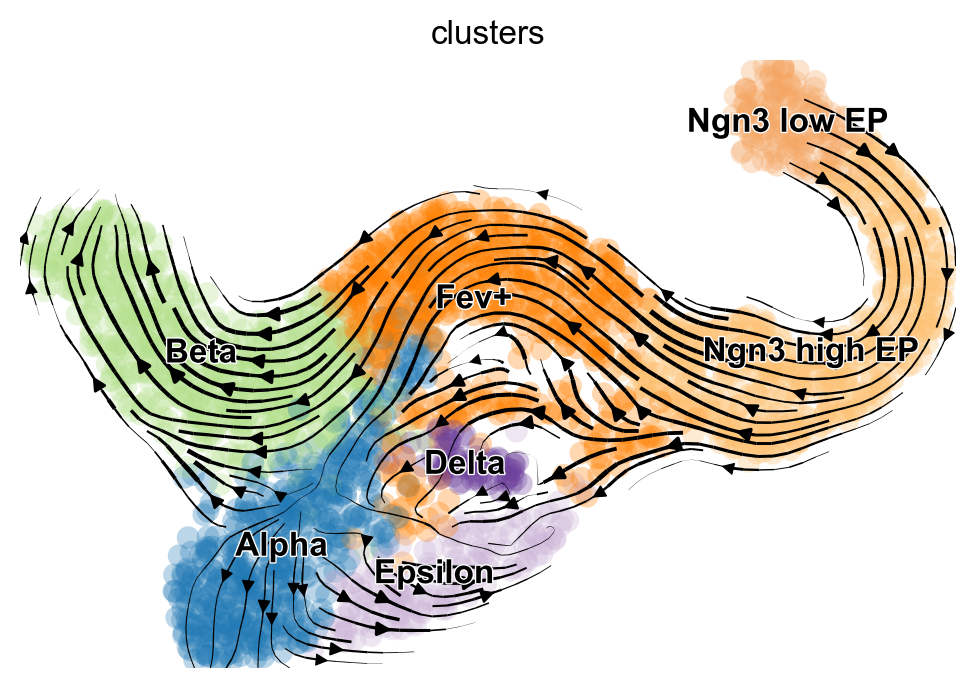

In [12]:
vk.plot_projection()

As shown before in the scVelo publication <cite data-cite="bergen:20"></cite>, the projected velocity vectors capture the overall trend in this system: *Neurogenin 3* low endocrine progenitor cells (Ngn3 low EP) gradually transition via indermediate stages towards terminal, hormone producing Alpha, Beta, Epsilon and Delta cells. Another way to visualize this is via random walks: 

Simulating `100` random walks of maximum length `200`


    Finish (0:00:02)
Plotting random walks


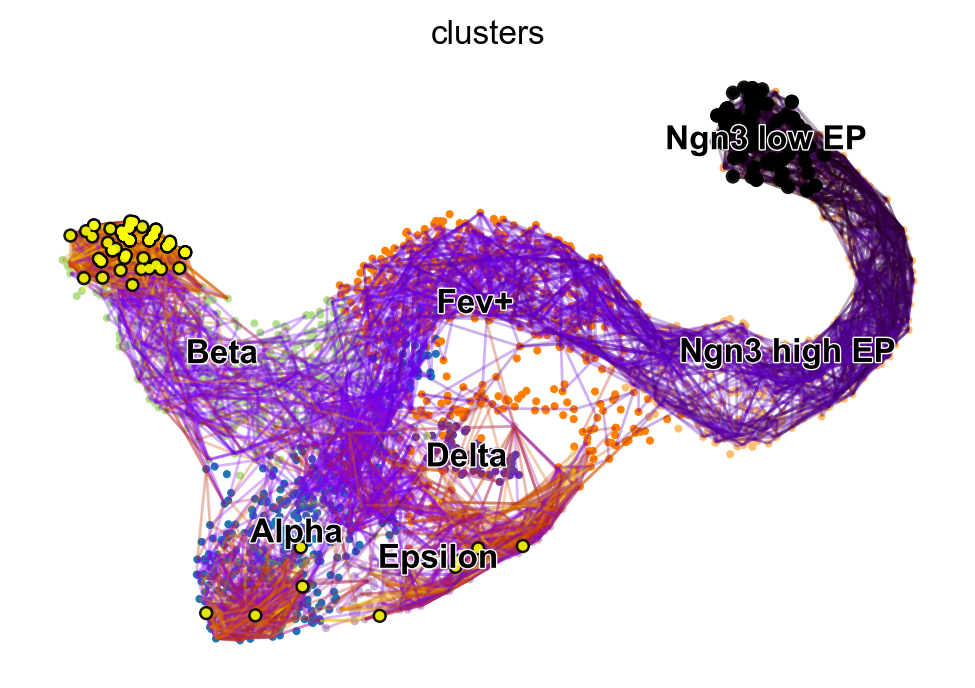

In [13]:
vk.plot_random_walks(start_ixs={'clusters':'Ngn3 low EP'}, max_iter=200)

We simulated 100 random walks which start in the `Ngn3 low EP` cluster. Black (yellow) dots denote the start (end) of a random walk. In agreement with known biology <cite data-cite="bastidas-ponce:19"></cite>, the Beta cluster is dominant at E15.5. 

## What's next? 

In this tutorial, you learned how to use CellRank to compute a transition matrix using RNA velocity and gene expression similarity and how it can be visualized in low dimensions. The real power of CellRank comes in when you use estimators to analyze the transition matrix directly, rather than projecting it. For the next steps, we recommend...

- going through the [initial & terminal states tutorial](https://cellrank.readthedocs.io/en/stable/initial_terminal.html) to learn how to use the transition matrix to automatically identify initial and terminal states. 
- reading the "CellRank for directed single-cell fate mapping" <cite data-cite="lange:22"></cite> paper to learn more about the methods we used here. 
- taking a look at the [full API](https://cellrank.readthedocs.io/en/stable/api.html) to learn about parameter values you can use to adapt these computations to your data. 

<div class="alert alert-info">
Important

If you encounter any bugs in the code, our if you have suggestions for new features, please open an [issue](https://github.com/theislab/cellrank/issues/new/choose). If you have a general question or something you would like to discuss with us, please post on the [scverse discourse](https://discourse.scverse.org/c/ecosytem/cellrank/40).

</div> 

## Package versions

We used the following package versions to generate this tutorial: 

In [14]:
cr.logging.print_versions()

cellrank==1.5.1+gc04c690e.d20220610 scanpy==1.7.2 anndata==0.8.0 numpy==1.21.4 numba==0.51.2 scipy==1.5.3 pandas==1.3.3 pygpcca==1.0.2 scikit-learn==0.24.0 statsmodels==0.12.1 python-igraph==0.8.3 scvelo==0.2.4 pygam==0.8.0 matplotlib==3.3.3 seaborn==0.11.0
